In [11]:
!pip install geopandas

   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   ------------------------------ --------- 256.0/338.4 kB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 338.4/338.4 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
    --------------------------------------- 0.3/19.2 MB 10.6 MB/s eta 0:00:02
   - -------------------------------------- 0.8/19.2 MB 13.0 MB/s eta 0:00:02
   -- ------------------------------------- 1.2/19.2 MB 11.2 MB/s eta 0:00:02
   ---- ----------------------------------- 2.0/19.2 MB 12.7 MB/s eta 0:00:02
   ----- ---------------------------------- 2.7/19.2 MB 13.0 MB/s eta 0:00:02
   ------ --------------------------------- 3.3/19.2 MB 12.2 MB/s eta 0:00:02
   ------- -------------------------------- 3.7/19.2 MB 12.6 MB/s eta 0:00:02
   -------- ------------------------------- 4.2/19.2 MB 12.1 MB/s eta 0:00:02
   --------- ------------------------------ 4.6/19.2 MB 11.7 MB/s eta 0:00:

In [3]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import folium

# Set directories
DATA_DIR = "./dataset/"
OUTPUT_DIR = "./processed_data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
def parse_google_takeout_json(user_id, file_path):
    """Parse Google Timeline JSON data into structured DataFrame."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return pd.DataFrame()

    records = []
    for timeline_obj in data.get('timelineObjects', []):
        # Activity Segments (movements)
        if 'activitySegment' in timeline_obj:
            segment = timeline_obj['activitySegment']
            try:
                records.append({
                    'user_id': user_id,
                    'type': 'activity',
                    'start_time': segment.get('duration', {}).get('startTimestamp'),
                    'end_time': segment.get('duration', {}).get('endTimestamp'),
                    'start_lat': segment.get('startLocation', {}).get('latitudeE7', 0) / 1e7,
                    'start_lon': segment.get('startLocation', {}).get('longitudeE7', 0) / 1e7,
                    'end_lat': segment.get('endLocation', {}).get('latitudeE7', 0) / 1e7,
                    'end_lon': segment.get('endLocation', {}).get('longitudeE7', 0) / 1e7,
                    'activity_type': max(
                        segment.get('activities', []),
                        key=lambda x: x.get('probability', 0),
                        default={'activityType': None}
                    )['activityType'],
                    'distance_meters': segment.get('distance', 0),
                    'confidence': segment.get('confidence')
                })
            except Exception as e:
                print(f"Error parsing activity in {file_path}: {str(e)}")
        
        # Place Visits (locations)
        elif 'placeVisit' in timeline_obj:
            visit = timeline_obj['placeVisit']
            try:
                records.append({
                    'user_id': user_id,
                    'type': 'place',
                    'start_time': visit.get('duration', {}).get('startTimestamp'),
                    'end_time': visit.get('duration', {}).get('endTimestamp'),
                    'lat': visit.get('location', {}).get('latitudeE7', 0) / 1e7,
                    'lon': visit.get('location', {}).get('longitudeE7', 0) / 1e7,
                    'place_name': visit.get('location', {}).get('name'),
                    'place_confidence': visit.get('placeConfidence')
                })
            except Exception as e:
                print(f"Error parsing place in {file_path}: {str(e)}")
    
    return pd.DataFrame(records)

# Process all users
all_data = pd.DataFrame()
for file in tqdm([f for f in os.listdir(DATA_DIR) if f.endswith('.json')]):
    user_id = file.split('.')[0]
    user_df = parse_google_takeout_json(user_id, os.path.join(DATA_DIR, file))
    all_data = pd.concat([all_data, user_df], ignore_index=True)

all_data['start_time'] = pd.to_datetime(
    all_data['start_time'], 
    format='ISO8601',  # Handles Zulu time and variable formats
    errors='coerce'    # Convert problematic dates to NaT instead of failing
)
all_data['end_time'] = pd.to_datetime(
    all_data['end_time'], 
    format='ISO8601',
    errors='coerce'
)

# Remove rows with invalid timestamps
all_data = all_data[all_data['start_time'].notna() & all_data['end_time'].notna()]

100%|██████████| 152/152 [00:02<00:00, 60.82it/s]


In [7]:
# Remove invalid coordinates
all_data = all_data[
    (all_data['start_lat'].between(-90, 90)) | 
    (all_data['type'] == 'place')
]
all_data = all_data[
    (all_data['start_lon'].between(-180, 180)) | 
    (all_data['type'] == 'place')
]

# Calculate activity durations
all_data['duration_minutes'] = (
    all_data['end_time'] - all_data['start_time']
).dt.total_seconds() / 60

In [9]:
def cluster_significant_locations(df, eps=0.002, min_samples=3):
    """Identify clusters of frequently visited places using DBSCAN."""
    places = df[df['type'] == 'place'].copy()
    if len(places) < min_samples:
        return None
    
    # Cluster coordinates
    coords = places[['lat', 'lon']].values
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    places['cluster'] = db.labels_
    
    # Calculate cluster stats
    cluster_stats = []
    for label in set(db.labels_):
        if label != -1:  # Skip noise
            cluster = places[places['cluster'] == label]
            cluster_stats.append({
                'lat': cluster['lat'].mean(),
                'lon': cluster['lon'].mean(),
                'visit_count': len(cluster),
                'avg_duration_min': cluster['duration_minutes'].mean(),
                'cluster_label': label
            })
    
    return pd.DataFrame(cluster_stats)

location_clusters = cluster_significant_locations(all_data)
location_clusters.to_csv(
    os.path.join(OUTPUT_DIR, 'location_clusters.csv'), 
    index=False
)

In [11]:
# Detect home (most frequent night location)
night_visits = all_data[
    (all_data['type'] == 'place') & 
    ((all_data['start_time'].dt.hour >= 22) | 
     (all_data['start_time'].dt.hour <= 6))
]
home_location = night_visits.groupby(['lat', 'lon']).size().idxmax()

# Detect work (most frequent weekday 9-5 location)
work_visits = all_data[
    (all_data['type'] == 'place') & 
    (all_data['start_time'].dt.weekday < 5) & 
    (all_data['start_time'].dt.hour.between(9, 17))
]
work_location = work_visits.groupby(['lat', 'lon']).size().idxmax()

print(f"Home location: {home_location}")
print(f"Work location: {work_location}")

Home location: (23.7265659, 90.3926596)
Work location: (23.7265659, 90.3926596)


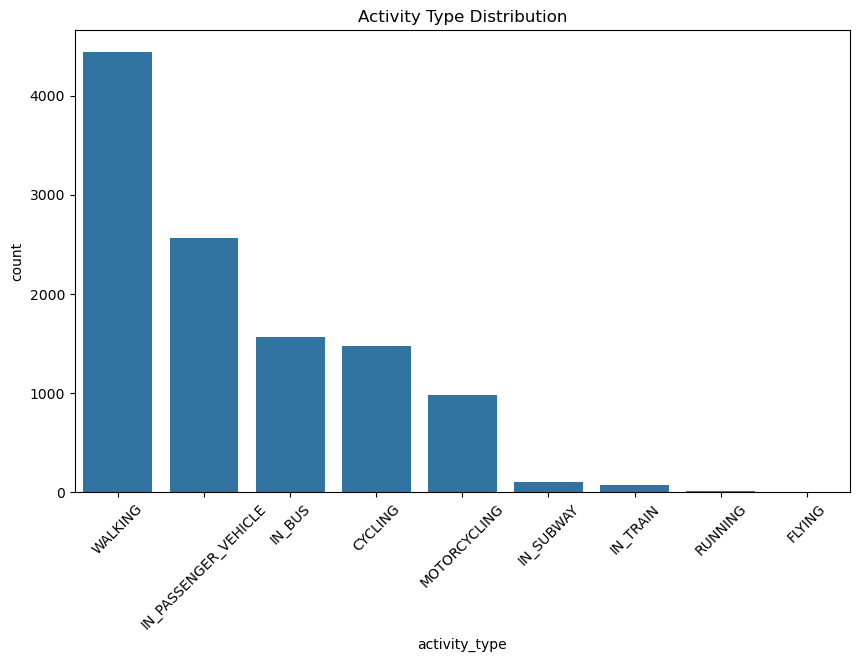

In [13]:
# 1. Activity Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    data=all_data[all_data['type'] == 'activity'],
    x='activity_type',
    order=all_data['activity_type'].value_counts().index
)
plt.xticks(rotation=45)
plt.title('Activity Type Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'activity_distribution.png'))

# 2. Interactive Map of Significant Locations
m = folium.Map(location=[all_data['lat'].mean(), all_data['lon'].mean()], zoom_start=12)
for _, row in location_clusters.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=row['visit_count'] / 10,
        popup=f"Visits: {row['visit_count']}",
        color='blue' if row['cluster_label'] % 2 else 'green'
    ).add_to(m)
m.save(os.path.join(OUTPUT_DIR, 'significant_locations_map.html'))

In [15]:
# Save processed data
all_data.to_csv(os.path.join(OUTPUT_DIR, 'processed_data.csv'), index=False)

# Generate report
report = f"""
=== Google Location Analysis Report ===
Total Users: {all_data['user_id'].nunique()}
Total Records: {len(all_data)}
- Activities: {len(all_data[all_data['type'] == 'activity'])}
- Places: {len(all_data[all_data['type'] == 'place'])}

Significant Locations Found: {len(location_clusters)}
Home Location: {home_location}
Work Location: {work_location}
"""
with open(os.path.join(OUTPUT_DIR, 'summary_report.txt'), 'w') as f:
    f.write(report)

In [17]:
import pandas as pd  
activities = pd.read_csv('processed_data/processed_data.csv').query('type == "activity"')  
print(activities['activity_type'].value_counts())  

activity_type
WALKING                 4438
IN_PASSENGER_VEHICLE    2564
IN_BUS                  1565
CYCLING                 1472
MOTORCYCLING             981
IN_SUBWAY                103
IN_TRAIN                  76
RUNNING                   18
FLYING                     5
Name: count, dtype: int64


<Axes: title={'center': 'Activity Frequencies'}, ylabel='activity_type'>

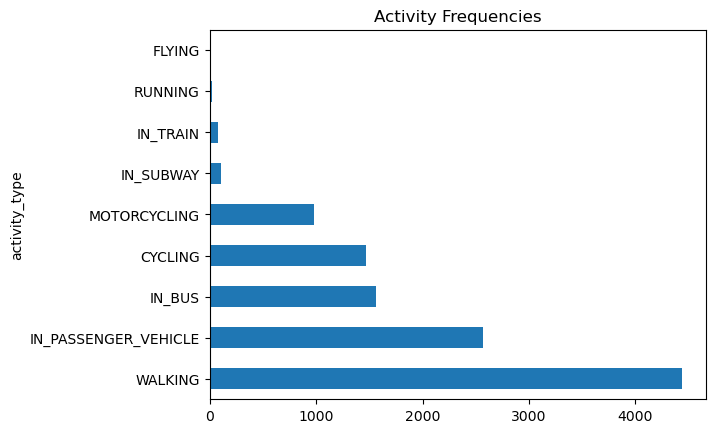

In [19]:
activities['activity_type'].value_counts().plot(kind='barh', title='Activity Frequencies')


In [21]:
# Install required packages first:
# pip install dash plotly

import dash
from dash import dcc, html
import plotly.express as px

# Create sample visualization
fig = px.scatter_mapbox(
    all_data[all_data['type'] == 'place'],
    lat="lat",
    lon="lon",
    color="user_id",
    hover_name="place_name",
    zoom=12
)
fig.update_layout(mapbox_style="open-street-map")

# Build Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Location Patterns Dashboard"),
    dcc.Graph(figure=fig),
    dcc.Slider(
        id='hour-slider',
        min=0,
        max=23,
        marks={i: str(i) for i in range(24)},
        value=12
    )
])

if __name__ == '__main__':
    app.run(debug=True)

In [82]:
!pip install geopy

   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --------- ----------------------------- 30.7/125.4 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------  122.9/125.4 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 125.4/125.4 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 2.0 MB/s eta 0:00:00


In [107]:
!pip install xGBoost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 1.4 MB/s eta 0:01:50
   ---------------------------------------- 0.4/150.0 MB 6.1 MB/s eta 0:00:25
   ---------------------------------------- 0.9/150.0 MB 8.0 MB/s eta 0:00:19
   ---------------------------------------- 1.5/150.0 MB 9.5 MB/s eta 0:00:16
    --------------------------------------- 2.0/150.0 MB 9.8 MB/s eta 0:00:16
    --------------------------------------- 2.6/150.0 MB 10.5 MB/s eta 0:00:14
    --------------------------------------- 3.3/150.0 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 4.0/150.0 MB 11.7 MB/s eta 0:00:13
   - -------------------------------------- 4.8/150.0 MB 12.2 MB/s eta 0:00:12
   - -------------------------------------- 5.5/150.0 MB 12.5 MB/s eta 0:00:12
   - -------------------------------------- 6.2/150.0 MB 12.9 MB/s eta 0:00:12
   - -------------------------------------- 7.0/150.0 MB 13.2 MB/

In [23]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from geopy.distance import geodesic
import joblib
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Optional: For deep learning models
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False

# Constants
MIN_POOLED_SAMPLES = 50
MIN_USER_SAMPLES = 10
N_STEPS = 3

def enhanced_create_sequences(df, user_id, n_steps=N_STEPS):
    """Generates sequences with temporal and spatial features"""
    try:
        user_data = df[(df['user_id'] == user_id) & 
                     (df['type'] == 'place')].sort_values('start_time')
        
        if len(user_data) < n_steps + 1:
            return np.array([]), np.array([])
        
        features, labels = [], []
        for i in range(len(user_data) - n_steps):
            window = user_data.iloc[i:i+n_steps]
            next_point = user_data.iloc[i+n_steps]
            
            try:
                movement_dist = geodesic((window['lat'].iloc[0], window['lon'].iloc[0]),
                                     (window['lat'].iloc[-1], window['lon'].iloc[-1])).meters
            except:
                movement_dist = 0
            
            features.append([
                window['lat'].mean(),
                window['lon'].mean(),
                window['lat'].std() or 0.0001,
                window['lon'].std() or 0.0001,
                window['duration_minutes'].mean(),
                window['duration_minutes'].std() or 1,
                window['start_time'].iloc[-1].hour,
                window['start_time'].iloc[-1].weekday(),
                movement_dist,
                window['start_time'].iloc[-1].month,
                (window['start_time'].iloc[-1] - window['start_time'].iloc[0]).total_seconds()/3600
            ])
            labels.append([next_point['lat'], next_point['lon']])
        
        return np.array(features), np.array(labels)
    except Exception as e:
        print(f"Error creating sequences for user {user_id}: {str(e)}")
        return np.array([]), np.array([])

def create_pooled_data(df, n_steps=N_STEPS):
    """Generates combined dataset from all users"""
    pooled_features, pooled_labels = [], []
    
    for user_id in df['user_id'].unique():
        X_user, y_user = enhanced_create_sequences(df, user_id, n_steps)
        if len(X_user) > 0:
            pooled_features.append(X_user)
            pooled_labels.append(y_user)
    
    return np.vstack(pooled_features), np.vstack(pooled_labels)

def create_lstm_model(input_shape, output_dim=2):
    """Create LSTM model for sequence prediction"""
    if not KERAS_AVAILABLE:
        return None
    
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def get_model_configurations():
    """Return dictionary of all models to test"""
    models = {
        'XGBoost': {
            'estimator': XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=7,
                min_child_weight=10,
                random_state=42,
                tree_method='hist',
                subsample=0.8,
                colsample_bytree=0.8
            ),
            'multioutput': True,
            'category': 'Gradient Boosting'
        },
        'LightGBM': {
            'estimator': LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=7,
                min_child_samples=10,
                random_state=42,
                subsample=0.8,
                colsample_bytree=0.8,
                verbosity=-1
            ),
            'multioutput': True,
            'category': 'Gradient Boosting'
        },
        'CatBoost': {
            'estimator': CatBoostRegressor(
                n_estimators=200,
                learning_rate=0.05,
                depth=7,
                min_data_in_leaf=10,
                random_state=42,
                verbose=False
            ),
            'multioutput': True,
            'category': 'Gradient Boosting'
        },
        'Random Forest': {
            'estimator': RandomForestRegressor(
                n_estimators=200,
                max_depth=10,
                min_samples_leaf=10,
                random_state=42,
                n_jobs=-1
            ),
            'multioutput': True,
            'category': 'Classical ML'
        },
        'Gradient Boosting': {
            'estimator': GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=7,
                min_samples_leaf=10,
                random_state=42
            ),
            'multioutput': True,
            'category': 'Classical ML'
        },
        'SVM (RBF)': {
            'estimator': SVR(
                kernel='rbf',
                C=1.0,
                gamma='scale',
                epsilon=0.1
            ),
            'multioutput': True,
            'category': 'Classical ML'
        }
    }
    
    return models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a single model and return metrics"""
    start_time = time.time()
    
    try:
        # Train model
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        return {
            'model': model_name,
            'r2_score': r2,
            'rmse': rmse,
            'training_time': training_time
        }
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return {
            'model': model_name,
            'r2_score': np.nan,
            'rmse': np.nan,
            'training_time': np.nan
        }

def train_and_compare_models(all_data):
    """Train multiple models and generate comparison table"""
    # Prepare data
    X_pooled, y_pooled = create_pooled_data(all_data)
    
    if len(X_pooled) < MIN_POOLED_SAMPLES:
        print(f"Insufficient pooled data ({len(X_pooled)} samples). Need at least {MIN_POOLED_SAMPLES}.")
        return None

    imputer = SimpleImputer(strategy='mean')   # You can change strategy ('median', 'most_frequent', etc.)
    X_pooled_imputed = imputer.fit_transform(X_pooled)

    # Scale features
    scaler = RobustScaler()
    X_pooled_scaled = scaler.fit_transform(X_pooled)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_pooled_scaled, y_pooled, test_size=0.2, random_state=42
    )
    
    # Get model configurations
    model_configs = get_model_configurations()
    
    # Store results
    results = []
    trained_models = {}
    
    print("Training and evaluating models...")
    print("=" * 50)
    
    # Cross-validation setup
    tscv = TimeSeriesSplit(n_splits=3)
    
    for model_name, config in model_configs.items():
        print(f"Training {model_name}...")
        
        # Create model
        if config['multioutput']:
            model = MultiOutputRegressor(config['estimator'])
        else:
            model = config['estimator']
        
        # Cross-validation
        try:
            cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
            cv_mean = np.mean(cv_scores)
            cv_std = np.std(cv_scores)
        except:
            cv_mean, cv_std = np.nan, np.nan
        
        # Single evaluation
        metrics = evaluate_model(
            clone(model), X_train, X_test, y_train, y_test, model_name
        )
        
        # Store results
        results.append({
            'Model': model_name,
            'Category': config['category'],
            'CV R² Mean': cv_mean,
            'CV R² Std': cv_std,
            'Test R²': metrics['r2_score'],
            'RMSE': metrics['rmse'],
            'Training Time (s)': metrics['training_time']
        })
        
        # Save best performing model
        if not np.isnan(metrics['r2_score']):
            final_model = clone(model)
            final_model.fit(X_train, y_train)
            trained_models[model_name] = final_model
        
        print(f"  R²: {metrics['r2_score']:.3f}, RMSE: {metrics['rmse']:.3f}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Add interpretability and best use case columns
    interpretability_map = {
        'XGBoost': 'Medium',
        'LightGBM': 'Medium', 
        'CatBoost': 'Medium',
        'Random Forest': 'High',
        'Gradient Boosting': 'Medium',
        'SVM (RBF)': 'Low'
    }
    
    best_for_map = {
        'XGBoost': 'General performance',
        'LightGBM': 'Speed and efficiency',
        'CatBoost': 'Categorical features',
        'Random Forest': 'Interpretability',
        'Gradient Boosting': 'Baseline comparison',
        'SVM (RBF)': 'Non-linear patterns'
    }
    
    results_df['Interpretability'] = results_df['Model'].map(interpretability_map)
    results_df['Best For'] = results_df['Model'].map(best_for_map)
    
    # Format results for publication
    results_df['Avg. R² (CV)'] = results_df.apply(
        lambda row: f"{row['CV R² Mean']:.2f} ± {row['CV R² Std']:.2f}" 
        if not np.isnan(row['CV R² Mean']) else 'N/A', axis=1
    )
    
    results_df['Training Time'] = results_df['Training Time (s)'].apply(
        lambda x: f"{x:.1f}s" if not np.isnan(x) else 'N/A'
    )
    
    # Final formatted table for publication
    publication_df = results_df[[
        'Model', 'Category', 'Avg. R² (CV)', 'RMSE', 
        'Training Time', 'Interpretability', 'Best For'
    ]].copy()
    
    # Sort by Test R² (descending)
    publication_df = publication_df.loc[results_df['Test R²'].sort_values(ascending=False).index]
    
    # Save results
    results_df.to_csv('processed_data/model_comparison_detailed.csv', index=False)
    publication_df.to_csv('processed_data/model_comparison_publication.csv', index=False)
    
    # Save best model
    best_model_name = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
    best_model = trained_models[best_model_name]
    
    joblib.dump({
        'model': best_model,
        'scaler': scaler,
        'model_name': best_model_name,
        'performance': results_df.loc[results_df['Model'] == best_model_name].iloc[0].to_dict()
    }, 'processed_data/best_model.joblib')
    
    print("\n" + "="*70)
    print("MODEL COMPARISON TABLE FOR RESEARCH PAPER")
    print("="*70)
    print(publication_df.to_string(index=False))
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"Best R²: {results_df['Test R²'].max():.3f}")
    
    return publication_df, trained_models

def fine_tune_best_models(all_data, trained_models, top_n=3):
    """Fine-tune top N models for individual users"""
    # Get performance data
    results_df = pd.read_csv('processed_data/model_comparison_detailed.csv')
    top_models = results_df.nlargest(top_n, 'Test R²')['Model'].tolist()
    
    print(f"\nFine-tuning top {top_n} models per user: {top_models}")
    
    for user_id in all_data['user_id'].unique():
        X_user, y_user = enhanced_create_sequences(all_data, user_id)
        
        if len(X_user) < MIN_USER_SAMPLES:
            continue
            
        user_scaler = RobustScaler()
        X_user_scaled = user_scaler.fit_transform(X_user)
        
        user_models = {}
        for model_name in top_models:
            if model_name in trained_models:
                user_model = clone(trained_models[model_name])
                user_model.fit(X_user_scaled, y_user)
                user_models[model_name] = user_model
        
        # Save user-specific models
        joblib.dump({
            'models': user_models,
            'scaler': user_scaler,
            'user_id': user_id
        }, f'processed_data/user_models_{user_id}.joblib')

if __name__ == "__main__":
    # Load your data here
    all_data = pd.read_csv("processed_data/processed_data.csv", parse_dates=['start_time'])
    all_data['start_time'] = pd.to_datetime(all_data['start_time'], errors='coerce')
    all_data = all_data.dropna(subset=['start_time'])


    
    if 'all_data' in globals():
        # Train and compare models
        comparison_table, models = train_and_compare_models(all_data)
        
        # Fine-tune best models per user
        fine_tune_best_models(all_data, models)
        
        print("\nModel comparison complete! Check 'processed_data/' for saved results.")
    else:
        print("Data not loaded. Please load your data into 'all_data' variable.")


Training and evaluating models...
Training XGBoost...
  R²: 0.866, RMSE: 0.125
Training LightGBM...
  R²: 0.862, RMSE: 0.127
Training CatBoost...
  R²: 0.864, RMSE: 0.126
Training Random Forest...
  R²: 0.873, RMSE: 0.122
Training Gradient Boosting...
  R²: 0.869, RMSE: 0.124
Training SVM (RBF)...
  R²: 0.866, RMSE: 0.125

MODEL COMPARISON TABLE FOR RESEARCH PAPER
            Model          Category Avg. R² (CV)     RMSE Training Time Interpretability             Best For
    Random Forest      Classical ML  0.84 ± 0.03 0.122062          1.2s             High     Interpretability
Gradient Boosting      Classical ML  0.83 ± 0.03 0.123794          9.1s           Medium  Baseline comparison
        SVM (RBF)      Classical ML  0.81 ± 0.04 0.125260          0.1s              Low  Non-linear patterns
          XGBoost Gradient Boosting  0.84 ± 0.03 0.125171          0.2s           Medium  General performance
         CatBoost Gradient Boosting  0.84 ± 0.03 0.125919          1.0s           M

In [24]:
import pandas as pd
import numpy as np
import joblib
from geopy.distance import geodesic
from sklearn.preprocessing import RobustScaler

# Constants (must match training)
N_STEPS = 3  # use the same as in training (3 in your code)
MIN_USER_SAMPLES = 10  # only used to warn; prediction needs at least N_STEPS rows

def build_single_inference_feature_window(user_df, n_steps=N_STEPS):
    """
    Build a single feature vector from the user's last n_steps 'place' rows,
    following the exact feature engineering used in training.
    
    Returns:
        feature_vector: shape (1, n_features) numpy array
        ok: boolean indicating if enough history exists
    """
    # Ensure sorting and 'place' filtering exactly as training
    user_data = user_df[user_df['type'] == 'place'].sort_values('start_time')
    if len(user_data) < n_steps + 1:
        return None, False
    
    # Take the last n_steps window
    window = user_data.iloc[-n_steps:]
    
    # Compute movement distance across window
    try:
        movement_dist = geodesic(
            (window['lat'].iloc[0], window['lon'].iloc[0]),
            (window['lat'].iloc[-1], window['lon'].iloc[-1])
        ).meters
    except Exception:
        movement_dist = 0.0
    
    # Extract temporal features from last record in the window
    last_time = window['start_time'].iloc[-1]
    first_time = window['start_time'].iloc[0]
    elapsed_hours = (last_time - first_time).total_seconds() / 3600.0
    
    # Protect against zero std
    lat_std = window['lat'].std()
    lon_std = window['lon'].std()
    dur_std = window['duration_minutes'].std()
    lat_std = lat_std if pd.notnull(lat_std) and lat_std > 0 else 0.0001
    lon_std = lon_std if pd.notnull(lon_std) and lon_std > 0 else 0.0001
    dur_std = dur_std if pd.notnull(dur_std) and dur_std > 0 else 1.0
    
    feature_vector = np.array([[
        window['lat'].mean(),
        window['lon'].mean(),
        lat_std,
        lon_std,
        window['duration_minutes'].mean(),
        dur_std,
        last_time.hour,
        last_time.weekday(),
        movement_dist,
        last_time.month,
        elapsed_hours
    ]], dtype=float)
    
    return feature_vector, True


In [27]:
# Configuration
DATA_PATH = "processed_data/processed_data.csv"           # your pooled CSV
BEST_MODEL_PATH = "processed_data/best_model.joblib"      # saved by your training script
TARGET_USER_ID = "1804037_JULY"                           # example; set dynamically

# 1) Load data
all_data = pd.read_csv(DATA_PATH)
all_data['start_time'] = pd.to_datetime(all_data['start_time'], errors='coerce')
all_data = all_data.dropna(subset=['start_time', 'lat', 'lon', 'duration_minutes', 'type', 'user_id'])

# 2) Slice a single user
user_df = all_data[all_data['user_id'] == TARGET_USER_ID].copy()
if user_df.empty:
    raise ValueError(f"No rows found for user_id={TARGET_USER_ID}")

# 3) Build last window features
X_feature, ok = build_single_inference_feature_window(user_df, n_steps=N_STEPS)
if not ok:
    raise ValueError(
        f"Insufficient history: need at least {N_STEPS+1} 'place' rows, "
        f"found {len(user_df[user_df['type']=='place'])}."
    )

# 4) Load best model package (model + scaler)
bundle = joblib.load(BEST_MODEL_PATH)
best_model = bundle['model']      # already a fitted estimator (likely MultiOutputRegressor(RandomForestRegressor))
scaler = bundle['scaler']         # RobustScaler fitted on pooled training features
best_model_name = bundle.get('model_name', 'BestModel')

# 5) Scale features and predict
X_feature_scaled = scaler.transform(X_feature)
next_latlon = best_model.predict(X_feature_scaled)

print(f"Using model: {best_model_name}")
print(f"Predicted next location [lat, lon]: {next_latlon.ravel().tolist()}")


Using model: Random Forest
Predicted next location [lat, lon]: [23.740668263582375, 90.39320282598086]


In [29]:
import pandas as pd
import numpy as np
import joblib
from geopy.distance import geodesic

# Configuration
DATA_PATH = "processed_data/processed_data.csv"
BEST_MODEL_PATH = "processed_data/best_model.joblib"
N_STEPS = 3  # must match training

def build_single_inference_feature_window(user_df, n_steps=N_STEPS):
    """
    Build a single feature vector from the user's last n_steps 'place' rows,
    following the exact feature engineering used in training.
    
    Returns:
        feature_vector: shape (1, n_features) numpy array
        ok: boolean indicating if enough history exists
    """
    # Ensure sorting and 'place' filtering exactly as training
    user_data = user_df[user_df['type'] == 'place'].sort_values('start_time')
    if len(user_data) < n_steps:
        return None, False
    
    # Take the last n_steps window
    window = user_data.iloc[-n_steps:]
    
    # Compute movement distance across window
    try:
        movement_dist = geodesic(
            (window['lat'].iloc[0], window['lon'].iloc[0]),
            (window['lat'].iloc[-1], window['lon'].iloc[-1])
        ).meters
    except Exception:
        movement_dist = 0.0
    
    # Extract temporal features from last record in the window
    last_time = window['start_time'].iloc[-1]
    first_time = window['start_time'].iloc[0]
    elapsed_hours = (last_time - first_time).total_seconds() / 3600.0
    
    # Protect against zero std
    lat_std = window['lat'].std()
    lon_std = window['lon'].std()
    dur_std = window['duration_minutes'].std()
    lat_std = lat_std if pd.notnull(lat_std) and lat_std > 0 else 0.0001
    lon_std = lon_std if pd.notnull(lon_std) and lon_std > 0 else 0.0001
    dur_std = dur_std if pd.notnull(dur_std) and dur_std > 0 else 1.0
    
    feature_vector = np.array([[
        window['lat'].mean(),
        window['lon'].mean(),
        lat_std,
        lon_std,
        window['duration_minutes'].mean(),
        dur_std,
        last_time.hour,
        last_time.weekday(),
        movement_dist,
        last_time.month,
        elapsed_hours
    ]], dtype=float)
    
    return feature_vector, True

def predict_for_user_df(user_df, bundle, n_steps):
    """
    Predict next location for a single user DataFrame
    """
    X_feature, ok = build_single_inference_feature_window(user_df, n_steps=n_steps)
    if not ok:
        return None
    
    scaler = bundle['scaler']
    model = bundle['model']
    X_scaled = scaler.transform(X_feature)
    pred = model.predict(X_scaled).ravel()
    return {'lat': float(pred[0]), 'lon': float(pred[1])}

def predict_random_users(all_data, bundle, n_users=5, seed=42):
    """
    Predict next locations for random users
    """
    # Filter to user_ids that have at least N_STEPS "place" rows
    eligible = (
        all_data[all_data['type'] == 'place']
        .groupby('user_id')
        .size()
        .reset_index(name='cnt')
    )
    eligible_ids = eligible.loc[eligible['cnt'] >= N_STEPS, 'user_id'].tolist()
    
    if len(eligible_ids) == 0:
        print("No eligible users found with sufficient data.")
        return []
    
    # Sample random user_ids
    rng = np.random.default_rng(seed=seed)
    sample_size = min(n_users, len(eligible_ids))
    sample_ids = rng.choice(eligible_ids, size=sample_size, replace=False)
    
    # Predict for each sampled user
    results = []
    for uid in sample_ids:
        user_df = all_data[all_data['user_id'] == uid].sort_values('start_time').copy()
        pred = predict_for_user_df(user_df, bundle, N_STEPS)
        if pred is not None:
            results.append({
                'user_id': uid, 
                'pred_lat': pred['lat'], 
                'pred_lon': pred['lon']
            })
            print(f"{uid} -> [lat, lon] = [{pred['lat']:.6f}, {pred['lon']:.6f}]")
        else:
            print(f"{uid} -> insufficient history for prediction")
    
    return results

def predict_all_eligible_users(all_data, bundle):
    """
    Predict next locations for ALL eligible users (batch processing)
    """
    # Filter to user_ids that have at least N_STEPS "place" rows
    eligible = (
        all_data[all_data['type'] == 'place']
        .groupby('user_id')
        .size()
        .reset_index(name='cnt')
    )
    eligible_ids = eligible.loc[eligible['cnt'] >= N_STEPS, 'user_id'].tolist()
    
    print(f"Processing {len(eligible_ids)} eligible users...")
    
    results = []
    for i, uid in enumerate(eligible_ids, 1):
        user_df = all_data[all_data['user_id'] == uid].sort_values('start_time').copy()
        pred = predict_for_user_df(user_df, bundle, N_STEPS)
        if pred is not None:
            results.append({
                'user_id': uid, 
                'pred_lat': pred['lat'], 
                'pred_lon': pred['lon']
            })
        
        # Progress indicator
        if i % 100 == 0:
            print(f"Processed {i}/{len(eligible_ids)} users...")
    
    return results

if __name__ == "__main__":
    # 1) Load data
    all_data = pd.read_csv(DATA_PATH)
    all_data['start_time'] = pd.to_datetime(all_data['start_time'], errors='coerce')
    all_data = all_data.dropna(subset=['start_time', 'lat', 'lon', 'duration_minutes', 'type', 'user_id'])
    
    # 2) Load model bundle once
    bundle = joblib.load(BEST_MODEL_PATH)
    model_name = bundle.get('model_name', 'BestModel')
    print(f"Using model: {model_name}")
    print("=" * 50)
    
    # Option A: Predict for 5 random users
    print("OPTION A: Random Users Prediction")
    print("-" * 30)
    random_results = predict_random_users(all_data, bundle, n_users=5, seed=42)
    
    # Save random results to CSV
    if random_results:
        random_df = pd.DataFrame(random_results)
        random_df.to_csv("processed_data/random_user_predictions.csv", index=False)
        print(f"\nSaved {len(random_results)} random predictions to 'processed_data/random_user_predictions.csv'")
    
    print("\n" + "=" * 50)
    
    # Option B: Predict for ALL eligible users (uncomment if needed)
    # print("OPTION B: All Users Prediction")
    # print("-" * 30)
    # all_results = predict_all_eligible_users(all_data, bundle)
    # 
    # if all_results:
    #     all_df = pd.DataFrame(all_results)
    #     all_df.to_csv("processed_data/all_user_predictions.csv", index=False)
    #     print(f"Saved {len(all_results)} predictions to 'processed_data/all_user_predictions.csv'")
    
    # Option C: Interactive mode - pick different random users each run
    print("\nOPTION C: Different Random Users Each Run")
    print("-" * 40)
    interactive_results = predict_random_users(all_data, bundle, n_users=3, seed=None)  # seed=None for different results each time


Using model: Random Forest
OPTION A: Random Users Prediction
------------------------------
2104170_FEBRUARY -> [lat, lon] = [23.731837, 90.392549]
2008049_JULY -> [lat, lon] = [23.753825, 90.392565]
2104021_JANUARY -> [lat, lon] = [23.734655, 90.462566]
1804080_AUGUST -> [lat, lon] = [23.745823, 90.396932]
2008049_JANUARY -> [lat, lon] = [23.748652, 90.392574]

Saved 5 random predictions to 'processed_data/random_user_predictions.csv'


OPTION C: Different Random Users Each Run
----------------------------------------
2104170_JANUARY -> [lat, lon] = [23.733860, 90.387734]
1704083_JULY -> [lat, lon] = [23.742056, 90.378132]
2008049_JANUARY -> [lat, lon] = [23.748652, 90.392574]
